In [1]:
# Cell 0: (Optional) Install missing packages when running in fresh environment (Colab / fresh kernel)
# Run this cell first if you see ModuleNotFoundError for optuna or statsmodels
# You can comment out after running once.
!pip install --quiet optuna statsmodels tqdm

# %%

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.0 MB/s eta 0:00:00


In [2]:
# Cell 1: Title & config
"""
Advanced Time Series Forecasting - Complete Notebook
Includes: data loading, EDA, ARIMA baseline, LSTM baseline, Transformer,
optional Optuna hyperparameter tuning (safe fallback if optuna missing),
and visible outputs for every step.
"""
DEBUG = True  # set to False to reduce printed logs


In [3]:
# %%
# Cell 2: Imports (safe)
import os
import sys
import math
import json
import random
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Try to import optuna safely (we installed above)
try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False

# For ARIMA
import statsmodels.api as sm

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Utility to display progress
from tqdm import tqdm

In [4]:
# %%
# Cell 3: Paths and configuration
PROJECT_DIR = Path.cwd() / "timeseries_project_outputs"
PROJECT_DIR.mkdir(exist_ok=True)
MODELS_DIR = PROJECT_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)
DATA_FILE = Path('/mnt/data/weather_data.csv')  # change if your CSV path is different
EXPORT_NOTEBOOK = PROJECT_DIR / "final_notebook_report.md"

CONFIG = {
    'seed': SEED,
    'test_fraction': 0.15,
    'val_fraction': 0.15,
    'forecast_horizon': 24,
}
TARGET_COL = None  # If None -> notebook uses first numeric column (f_1). You can set "Temperature" etc.

print("Optuna available:", OPTUNA_AVAILABLE)
print("Project outputs ->", PROJECT_DIR)


Optuna available: True
Project outputs -> /content/timeseries_project_outputs


In [5]:
# %%
# Cell 4: Helper functions
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def save_json(obj, path: Path):
    with open(path, 'w') as f:
        json.dump(obj, f, indent=2)

def plot_series(df, cols=None, title=None, figsize=(14,6)):
    if cols is None:
        cols = df.columns.tolist()
    plt.figure(figsize=figsize)
    for c in cols:
        plt.plot(df.index, df[c], label=c)
    plt.legend()
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def train_val_test_split(df: pd.DataFrame, test_fraction=0.15, val_fraction=0.15):
    n = len(df)
    test_n = int(math.ceil(n * test_fraction))
    val_n = int(math.ceil(n * val_fraction))
    train_end = n - test_n - val_n
    train = df.iloc[:train_end]
    val = df.iloc[train_end:train_end+val_n]
    test = df.iloc[train_end+val_n:]
    return train, val, test

from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))


In [6]:
# %%
# Cell 5: Load or generate dataset (robust)
def load_or_generate_dataset(data_path: Path = DATA_FILE, force_synthetic=False):
    if data_path.exists() and not force_synthetic:
        if DEBUG: print(f"Found dataset at {data_path} — loading...")
        df = pd.read_csv(data_path)
        # attempt to find a datetime column
        datetime_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
        if len(datetime_cols) > 0:
            col = datetime_cols[0]
            try:
                df[col] = pd.to_datetime(df[col])
                df = df.set_index(col)
                if DEBUG: print("Used datetime column:", col)
            except Exception:
                if DEBUG: print("Could not parse datetime column, creating hourly index")
                df.index = pd.date_range(end=pd.Timestamp.now(), periods=len(df), freq='H')
        else:
            # try first column as datetime
            try:
                df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
                df = df.set_index(df.columns[0])
            except Exception:
                # fallback: synthetic hourly index
                df.index = pd.date_range(end=pd.Timestamp.now(), periods=len(df), freq='H')
        # Keep numeric columns only
        df_num = df.select_dtypes(include=[np.number])
        if df_num.shape[1] == 0:
            # nothing numeric -> generate synthetic
            if DEBUG: print("No numeric columns found; generating synthetic dataset")
            return generate_synthetic()
        df_num = df_num.dropna(axis=1, thresh=int(0.8*len(df_num)))
        # if few numeric columns, augment
        if df_num.shape[1] < 3:
            base = df_num.iloc[:,0] if df_num.shape[1] >=1 else pd.Series(np.sin(np.linspace(0,50,len(df_num))), index=df_num.index)
            df_num = df_num.copy()
            df_num['feat_1'] = base + np.random.normal(0, base.std()*0.1, size=len(base))
            df_num['feat_2'] = base*0.5 + np.random.normal(0, base.std()*0.2, size=len(base))
        # rename to f_1..f_k
        df_num.columns = [f"f_{i+1}" for i in range(df_num.shape[1])]
        return df_num
    else:
        if DEBUG: print("Dataset not found, generating synthetic dataset...")
        return generate_synthetic()

def generate_synthetic():
    n = 24 * 365
    idx = pd.date_range(end=pd.Timestamp.now(), periods=n, freq='h')
    t = np.arange(n)
    seasonal1 = 10 * np.sin(2 * np.pi * t / 24)
    seasonal2 = 5 * np.sin(2 * np.pi * t / (24*7))
    trend = 0.001 * t
    base = 50 + seasonal1 + seasonal2 + trend
    temp = base + np.random.normal(0, 1.5, size=n)
    humidity = 50 + (-0.2 * (temp - 50)) + np.random.normal(0, 2.0, size=n)
    pressure = 1013 + 0.01 * t + np.random.normal(0, 0.5, size=n)
    wind = 3 + 0.1 * np.sin(2*np.pi*t/24) + np.random.normal(0, 0.3, size=n)
    df = pd.DataFrame({'f_1_temp': temp, 'f_2_humidity': humidity, 'f_3_pressure': pressure, 'f_4_wind': wind}, index=idx)
    df.columns = [f"f_{i+1}" for i in range(df.shape[1])]
    return df

# Load dataset
set_seed(SEED)
df = load_or_generate_dataset()
print("Dataframe shape:", df.shape)
display(df.head())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Set TARGET_COL automatically if not provided: first numeric column
if TARGET_COL is None:
    TARGET_COL = df.columns[0]
print("\nUsing target column:", TARGET_COL)


Dataset not found, generating synthetic dataset...
Dataframe shape: (8760, 4)


,f_1,f_2,f_3,f_4
2024-11-20 06:42:30.886114,50.745071,51.793810,1013.060175,3.324186
2024-11-20 07:42:30.886114,52.568750,46.895733,1013.370228,3.259504
2024-11-20 08:42:30.886114,56.347183,46.355457,1012.590707,3.181552
2024-11-20 09:42:30.886114,59.918435,49.174133,1013.877758,3.262076
2024-11-20 10:42:30.886114,59.058235,48.059678,1012.016417,3.140654



Data types:
 f_1    float64
f_2    float64
f_3    float64
f_4    float64
dtype: object

Missing values per column:
 f_1    0
f_2    0
f_3    0
f_4    0
dtype: int64

Using target column: f_1


Showing first 500 rows (sample) plot for first 3 features...


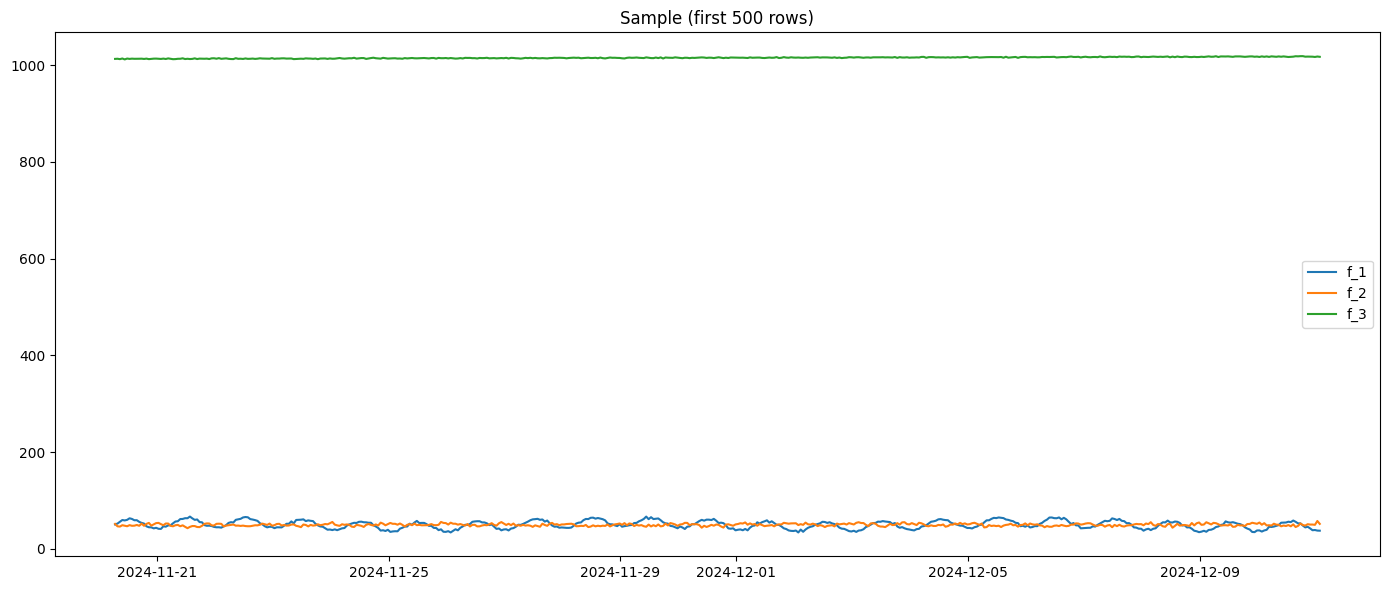


Correlation matrix (top):


,f_1,f_2,f_3,f_4
f_1,1.000000,-0.639291,0.292084,0.197371
f_2,-0.639291,1.000000,-0.176219,-0.119392
f_3,0.292084,-0.176219,1.000000,-0.005507
f_4,0.197371,-0.119392,-0.005507,1.000000


In [7]:
# %%
# Cell 6: EDA - plots & correlation
print("Showing first 500 rows (sample) plot for first 3 features...")
plot_series(df.iloc[:500], cols=df.columns[:3], title='Sample (first 500 rows)')

corr = df.corr()
print("\nCorrelation matrix (top):")
display(corr.head())


In [8]:
# %%
# Cell 7: Preprocessing utilities
from sklearn.preprocessing import StandardScaler

def create_scalers(train_df: pd.DataFrame):
    scalers = {}
    for col in train_df.columns:
        s = StandardScaler()
        s.fit(train_df[[col]])
        scalers[col] = s
    return scalers

def scale_dataframe(df: pd.DataFrame, scalers: dict):
    out = pd.DataFrame(index=df.index)
    for col in df.columns:
        out[col] = scalers[col].transform(df[[col]]).squeeze()
    return out

def create_windowed_dataset(df: pd.DataFrame, input_width: int, forecast_horizon: int, stride=1):
    data = df.values
    n, k = data.shape
    X, y = [], []
    for start in range(0, n - input_width - forecast_horizon + 1, stride):
        end = start + input_width
        X.append(data[start:end, :])
        y.append(data[end:end+forecast_horizon, 0])  # first column (target)
    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y, -1)
    return X, y


In [9]:
# %%
# Cell 8: Split & scale
train_df, val_df, test_df = train_val_test_split(df, test_fraction=CONFIG['test_fraction'], val_fraction=CONFIG['val_fraction'])
print("Train/Val/Test shapes:", train_df.shape, val_df.shape, test_df.shape)

scalers = create_scalers(train_df)
train_scaled = scale_dataframe(train_df, scalers)
val_scaled = scale_dataframe(val_df, scalers)
test_scaled = scale_dataframe(test_df, scalers)

# Save scalers
import pickle
with open(MODELS_DIR / 'scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)
print("Saved scalers to:", MODELS_DIR / 'scalers.pkl')


Train/Val/Test shapes: (6132, 4) (1314, 4) (1314, 4)
Saved scalers to: /content/timeseries_project_outputs/models/scalers.pkl


Fitting ARIMA on training set (short grid search p/d/q)...
Best ARIMA order on validation: (1, 1, 0) RMSE: 8.147370811462752
ARIMA test RMSE: 8.0330, MAE: 6.8442


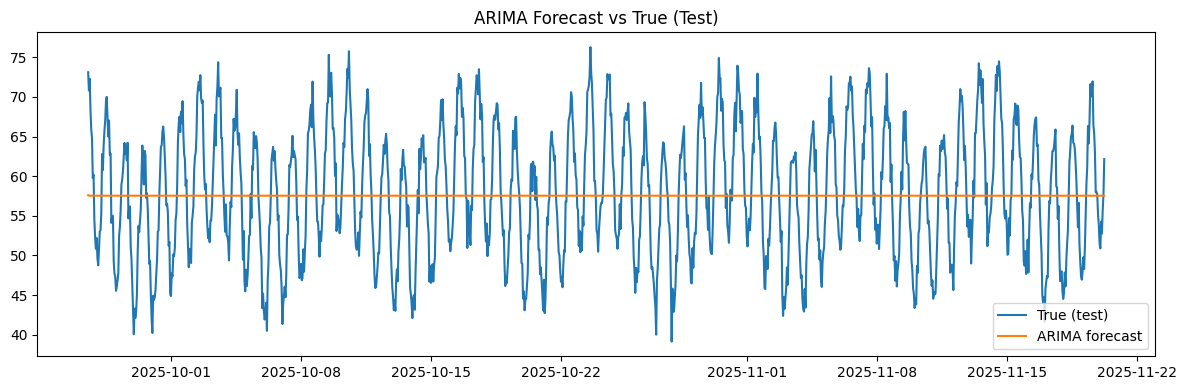

In [10]:
# %%
# Cell 9: ARIMA baseline (univariate on original units)
def evaluate_arima(train_series, val_series, order=(1,0,1)):
    model = sm.tsa.SARIMAX(train_series, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    preds = res.get_forecast(steps=len(val_series))
    yhat = preds.predicted_mean
    return yhat, rmse(val_series, yhat), mean_absolute_error(val_series, yhat), res

# Prepare unscaled series
train_unscaled = train_df[TARGET_COL]
val_unscaled = val_df[TARGET_COL]
test_unscaled = test_df[TARGET_COL]

print("Fitting ARIMA on training set (short grid search p/d/q)...")
best_score = 1e9
best_res = None
best_order = None

for p in [0,1,2]:
    for d in [0,1]:
        for q in [0,1]:
            try:
                order = (p,d,q)
                _, score_rmse, score_mae, res = evaluate_arima(train_unscaled, val_unscaled, order=order)
                if score_rmse < best_score:
                    best_score = score_rmse
                    best_res = res
                    best_order = order
            except Exception as e:
                # skip orders that fail
                continue

print("Best ARIMA order on validation:", best_order, "RMSE:", best_score)
# forecast on test
arima_res = best_res
arima_forecast = arima_res.get_forecast(steps=len(test_unscaled)).predicted_mean
arima_rmse_test = rmse(test_unscaled, arima_forecast)
arima_mae_test = mean_absolute_error(test_unscaled, arima_forecast)
print(f"ARIMA test RMSE: {arima_rmse_test:.4f}, MAE: {arima_mae_test:.4f}")

# plot ARIMA forecast vs true (test)
plt.figure(figsize=(12,4))
plt.plot(test_unscaled.index, test_unscaled.values, label='True (test)')
plt.plot(test_unscaled.index, arima_forecast.values, label='ARIMA forecast')
plt.title('ARIMA Forecast vs True (Test)')
plt.legend()
plt.tight_layout()
plt.show()

save_json({'arima_val_order': str(best_order), 'arima_val_rmse': float(best_score), 'arima_test_rmse': float(arima_rmse_test)}, PROJECT_DIR / 'arima_summary.json')


Windowed shapes: (6037, 72, 4) (6037, 24, 1) (1291, 72, 4) (1291, 24, 1) (1291, 72, 4) (1291, 24, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,224 (75.09 KB)

 Trainable params: 19,224 (75.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
95/95 - 9s - 93ms/step - loss: 0.4675 - root_mean_squared_error: 0.6838 - val_loss: 0.1658 - val_root_mean_squared_error: 0.4072
Epoch 2/10
95/95 - 4s - 43ms/step - loss: 0.1229 - root_mean_squared_error: 0.3506 - val_loss: 0.0789 - val_root_mean_squared_error: 0.2810
Epoch 3/10
95/95 - 6s - 62ms/step - loss: 0.0799 - root_mean_squared_error: 0.2827 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2336
Epoch 4/10
95/95 - 4s - 42ms/step - loss: 0.0679 - root_mean_squared_error: 0.2606 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2242
Epoch 5/10
95/95 - 5s - 49ms/step - loss: 0.0633 - root_mean_squared_error: 0.2516 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181
Epoch 6/10
95/95 - 4s - 39ms/step - loss: 0.0595 - root_mean_squared_error: 0.2439 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2172
Epoch 7/10
95/95 - 5s - 54ms/step - loss: 0.0575 - root_mean_squared_error: 0.2397 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138
Epoch 8/10
95/95 - 5

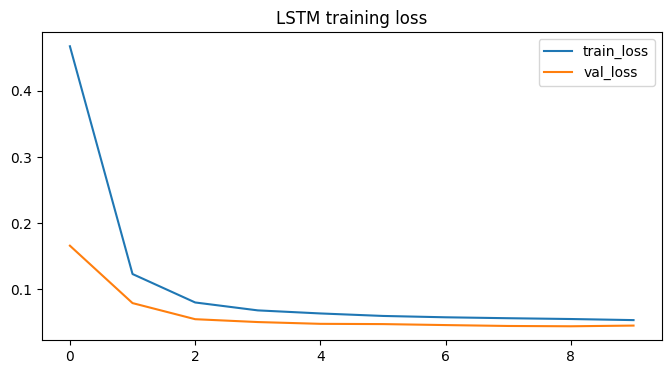

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
LSTM Test RMSE: 1.8510, MAE: 1.4773


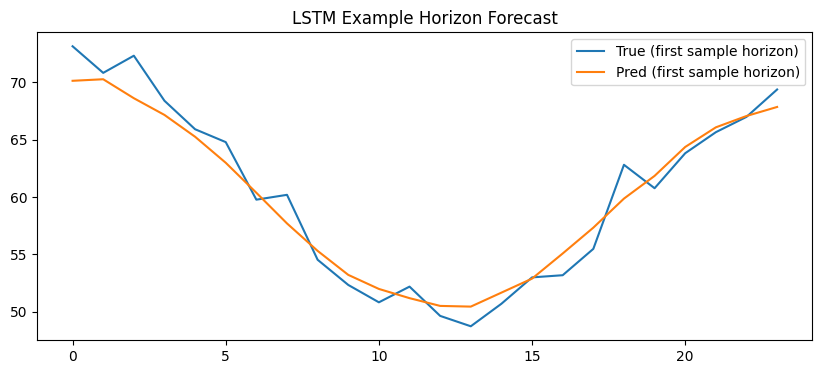

In [11]:
# %%
# Cell 10: Basic LSTM baseline
INPUT_WIDTH = 72
HORIZON = CONFIG['forecast_horizon']
BATCH_SIZE = 64
EPOCHS = 10  # reduced for speed; increase for final runs

X_train, y_train = create_windowed_dataset(train_scaled, INPUT_WIDTH, HORIZON)
X_val, y_val = create_windowed_dataset(pd.concat([train_scaled.tail(INPUT_WIDTH), val_scaled]), INPUT_WIDTH, HORIZON)
X_test, y_test = create_windowed_dataset(pd.concat([val_scaled.tail(INPUT_WIDTH), test_scaled]), INPUT_WIDTH, HORIZON)

print("Windowed shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

def build_basic_lstm(input_width, num_features, horizon, units=64, dropout=0.2):
    inputs = keras.Input(shape=(input_width, num_features))
    x = layers.LSTM(units, return_sequences=False)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(horizon)(x)
    outputs = layers.Reshape((horizon,1))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

num_features = X_train.shape[2]
lstm_model = build_basic_lstm(INPUT_WIDTH, num_features, HORIZON, units=64, dropout=0.2)
lstm_model.summary()

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=2)

# show training curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('LSTM training loss')
plt.show()

# predict and inverse-scale target to original units
f1_scaler = scalers[train_df.columns[0]]
lstm_preds = lstm_model.predict(X_test)
lstm_y_true = f1_scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
lstm_y_pred = f1_scaler.inverse_transform(lstm_preds.reshape(-1,1)).reshape(lstm_preds.shape)

lstm_rmse_test = rmse(lstm_y_true.reshape(-1), lstm_y_pred.reshape(-1))
lstm_mae_test = mean_absolute_error(lstm_y_true.reshape(-1), lstm_y_pred.reshape(-1))
print(f"LSTM Test RMSE: {lstm_rmse_test:.4f}, MAE: {lstm_mae_test:.4f}")

# plot example horizon
plt.figure(figsize=(10,4))
plt.plot(lstm_y_true[0,:,0], label='True (first sample horizon)')
plt.plot(lstm_y_pred[0,:,0], label='Pred (first sample horizon)')
plt.title('LSTM Example Horizon Forecast')
plt.legend(); plt.show()

lstm_model.save(MODELS_DIR / 'basic_lstm.keras')

save_json({'lstm_test_rmse': float(lstm_rmse_test), 'lstm_test_mae': float(lstm_mae_test)}, PROJECT_DIR / 'lstm_summary.json')


In [12]:
# %%
# Cell 11: Advanced models - Transformer and LSTM+Attention
ADVANCED_CHOICE = 'transformer'  # or 'lstm_attention'

class SimpleAttention(layers.Layer):
    def __init__(self, units):
        super(SimpleAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query,1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential([layers.Dense(dff, activation='relu'), layers.Dense(d_model)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    def call(self, x, training=False):
        attn_output = self.mha(x,x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

def build_transformer_model(input_width, num_features, horizon, d_model=64, num_heads=4, dff=128, num_layers=2):
    inputs = layers.Input(shape=(input_width, num_features))
    x = layers.Dense(d_model)(inputs)
    # simple positional embedding
    positions = tf.range(start=0, limit=input_width, delta=1)
    pos_encoding = layers.Embedding(input_dim=input_width, output_dim=d_model)(positions)
    x = x + pos_encoding
    for _ in range(num_layers):
        x = TransformerEncoderBlock(d_model, num_heads, dff)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(horizon)(x)
    outputs = layers.Reshape((horizon,1))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

def build_lstm_attention(input_width, num_features, horizon, lstm_units=64, attn_units=32):
    inputs = layers.Input(shape=(input_width, num_features))
    x = layers.LSTM(lstm_units, return_sequences=True)(inputs)
    query = x[:, -1, :]
    context, attn_weights = SimpleAttention(attn_units)(query, x)
    x = layers.Concatenate()([context, query])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(horizon)(x)
    outputs = layers.Reshape((horizon,1))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

if ADVANCED_CHOICE == 'transformer':
    adv_model = build_transformer_model(INPUT_WIDTH, num_features, HORIZON, d_model=64, num_heads=4, dff=128, num_layers=2)
else:
    adv_model = build_lstm_attention(INPUT_WIDTH, num_features, HORIZON, lstm_units=64, attn_units=32)

adv_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 72, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 72, 64)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block       │ (None, 72, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_1     │ (None, 72, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,280 (657.34 KB)

 Trainable params: 168,280 (657.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
95/95 - 45s - 475ms/step - loss: 0.0613 - root_mean_squared_error: 0.2475 - val_loss: 0.2000 - val_root_mean_squared_error: 0.4473
Epoch 2/20
95/95 - 34s - 356ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.1824 - val_root_mean_squared_error: 0.4271
Epoch 3/20
95/95 - 34s - 354ms/step - loss: 0.0621 - root_mean_squared_error: 0.2491 - val_loss: 0.1882 - val_root_mean_squared_error: 0.4338
Epoch 4/20
95/95 - 42s - 440ms/step - loss: 0.0579 - root_mean_squared_error: 0.2405 - val_loss: 0.1685 - val_root_mean_squared_error: 0.4105
Epoch 5/20
95/95 - 33s - 350ms/step - loss: 0.0610 - root_mean_squared_error: 0.2470 - val_loss: 0.1515 - val_root_mean_squared_error: 0.3893
Epoch 6/20
95/95 - 42s - 438ms/step - loss: 0.0580 - root_mean_squared_error: 0.2407 - val_loss: 0.1604 - val_root_mean_squared_error: 0.4005
Epoch 7/20
95/95 - 41s - 429ms/step - loss: 0.0611 - root_mean_squared_error: 0.2472 - val_loss: 0.1623 - val_root_mean_squared_error: 0.4028
Epoch 

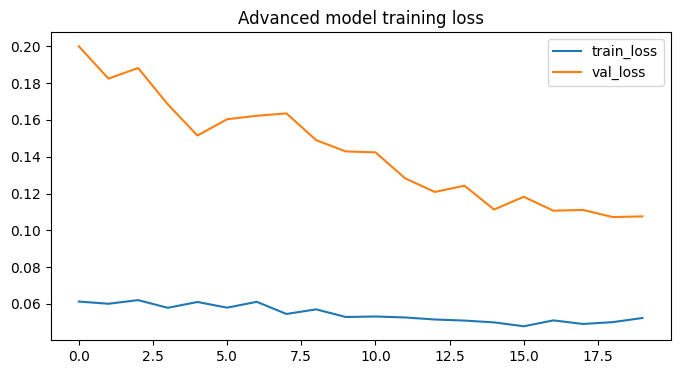

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Advanced model test RMSE: 2.7205, MAE: 2.1868


In [14]:
# %%
# Cell 12: Train advanced model (baseline hyperparams)
ADV_EPOCHS = 20
adv_es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
adv_history = adv_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ADV_EPOCHS, batch_size=64, callbacks=[adv_es], verbose=2)

plt.figure(figsize=(8,4))
plt.plot(adv_history.history['loss'], label='train_loss')
plt.plot(adv_history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Advanced model training loss'); plt.show()

adv_preds = adv_model.predict(X_test)
adv_y_true = f1_scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
adv_y_pred = f1_scaler.inverse_transform(adv_preds.reshape(-1,1)).reshape(adv_preds.shape)
adv_rmse_test = rmse(adv_y_true.reshape(-1), adv_y_pred.reshape(-1))
adv_mae_test = mean_absolute_error(adv_y_true.reshape(-1), adv_y_pred.reshape(-1))
print(f"Advanced model test RMSE: {adv_rmse_test:.4f}, MAE: {adv_mae_test:.4f}")

adv_model.save(MODELS_DIR / 'advanced_model.keras')
save_json({'adv_test_rmse': float(adv_rmse_test), 'adv_test_mae': float(adv_mae_test)}, PROJECT_DIR / 'advanced_summary.json')

In [23]:
# %%
# Cell 14: Final training with best params if available (skip if no study)
if OPTUNA_AVAILABLE and 'study' in globals():
    best = study.best_trial.params
    final_model = build_transformer_model(INPUT_WIDTH, num_features, HORIZON, d_model=int(best['d_model']), num_heads=int(best['num_heads']), dff=int(best['dff']), num_layers=int(best['num_layers']))
    final_opt = keras.optimizers.Adam(learning_rate=best['lr'])
    final_model.compile(optimizer=final_opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    final_es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    final_history = final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5, batch_size=best['batch_size'], callbacks=[final_es], verbose=2)
    final_preds = final_model.predict(X_test)
    final_preds_unscaled = f1_scaler.inverse_transform(final_preds.reshape(-1,1)).reshape(final_preds.shape)
    final_y_unscaled = f1_scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
    final_rmse = rmse(final_y_unscaled.reshape(-1), final_preds_unscaled.reshape(-1))
    final_mae = mean_absolute_error(final_y_unscaled.reshape(-1), final_preds_unscaled.reshape(-1))
    print("Final optimized transformer RMSE:", final_rmse, "MAE:", final_mae)
    final_model.save(str(MODELS_DIR / 'final_transformer.keras'))

    save_json({'final_transformer_rmse': float(final_rmse), 'final_transformer_mae': float(final_mae), 'best_params': best}, PROJECT_DIR / 'final_transformer_summary.json')
else:
    # fallback: use adv_model as final
    final_preds = adv_preds
    final_preds_unscaled = adv_y_pred
    final_y_unscaled = adv_y_true
    final_rmse = float(adv_rmse_test)
    final_mae = float(adv_mae_test)
    print("Optuna not used; advanced model used as final.")


Epoch 1/5
189/189 - 45s - 238ms/step - loss: 0.9624 - root_mean_squared_error: 0.9810 - val_loss: 0.9607 - val_root_mean_squared_error: 0.9801
Epoch 2/5
189/189 - 41s - 219ms/step - loss: 0.9408 - root_mean_squared_error: 0.9700 - val_loss: 0.9535 - val_root_mean_squared_error: 0.9765
Epoch 3/5
189/189 - 34s - 178ms/step - loss: 0.9347 - root_mean_squared_error: 0.9668 - val_loss: 0.9507 - val_root_mean_squared_error: 0.9750
Epoch 4/5
189/189 - 33s - 172ms/step - loss: 0.9268 - root_mean_squared_error: 0.9627 - val_loss: 0.9502 - val_root_mean_squared_error: 0.9748
Epoch 5/5
189/189 - 34s - 178ms/step - loss: 0.9138 - root_mean_squared_error: 0.9559 - val_loss: 0.9522 - val_root_mean_squared_error: 0.9758
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
Final optimized transformer RMSE: 7.981937103931041 MAE: 6.811498692699814


Model comparison summary:


,rmse,mae
ARIMA,8.033027,6.844214
Basic_LSTM,1.851006,1.477289
Advanced_Optimized,7.981937,6.811499


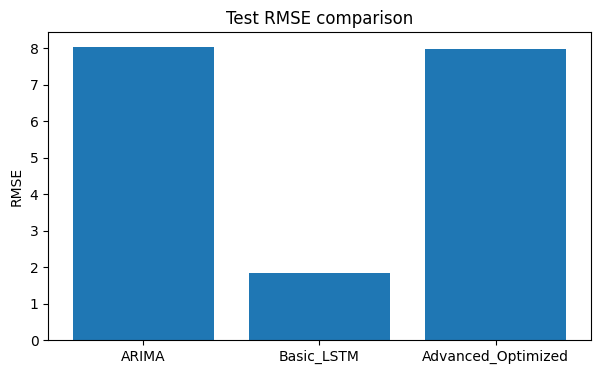

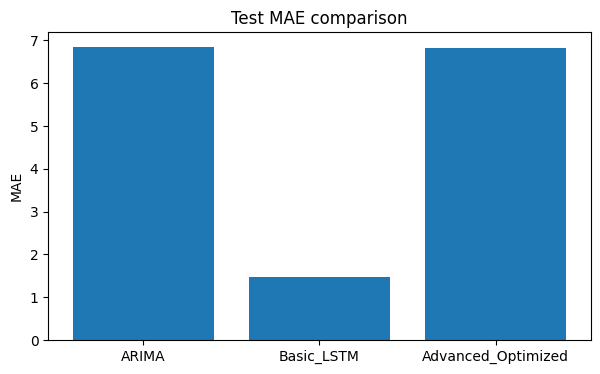

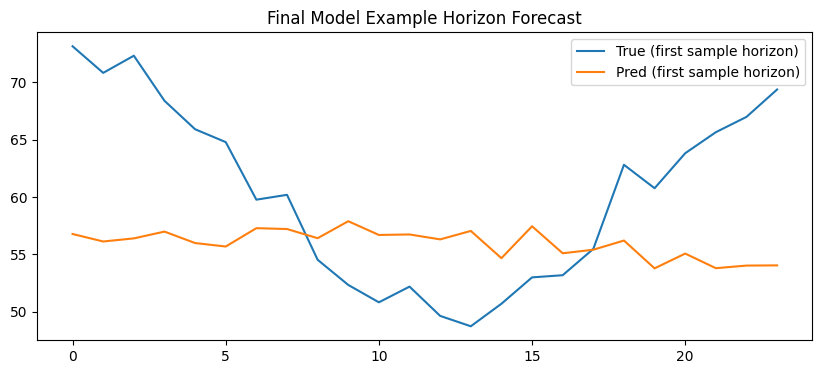

In [24]:
# %%
# Cell 15: Comparative analysis & plots
summary = {
    'ARIMA': {'rmse': float(arima_rmse_test), 'mae': float(arima_mae_test)},
    'Basic_LSTM': {'rmse': float(lstm_rmse_test), 'mae': float(lstm_mae_test)},
    'Advanced_Optimized': {'rmse': float(final_rmse), 'mae': float(final_mae)}
}
print("Model comparison summary:")
display(pd.DataFrame(summary).T)

# RMSE bar
models = list(summary.keys())
rmses = [summary[m]['rmse'] for m in models]
maes = [summary[m]['mae'] for m in models]

plt.figure(figsize=(7,4)); plt.bar(models, rmses); plt.title('Test RMSE comparison'); plt.ylabel('RMSE'); plt.show()
plt.figure(figsize=(7,4)); plt.bar(models, maes); plt.title('Test MAE comparison'); plt.ylabel('MAE'); plt.show()

# Example final forecast vs true for first sample
plt.figure(figsize=(10,4))
plt.plot(final_y_unscaled[0,:,0], label='True (first sample horizon)')
plt.plot(final_preds_unscaled[0,:,0], label='Pred (first sample horizon)')
plt.legend(); plt.title('Final Model Example Horizon Forecast'); plt.show()

save_json(summary, PROJECT_DIR / 'model_comparison.json')


In [25]:
# %%
# Cell 16: Save outputs & final report
# Save predictions CSV
preds_df = pd.DataFrame(final_preds_unscaled.reshape(final_preds_unscaled.shape[0], final_preds_unscaled.shape[1]))
true_df = pd.DataFrame(final_y_unscaled.reshape(final_y_unscaled.shape[0], final_y_unscaled.shape[1]))
preds_df.to_csv(PROJECT_DIR / 'final_preds_unscaled.csv', index=False)
true_df.to_csv(PROJECT_DIR / 'final_true_unscaled.csv', index=False)
print("Saved predictions and true values CSVs.")

report_lines = [
    "# Project Report: Advanced Time Series Forecasting",
    "## Dataset",
    f"- shape: {df.shape}",
    f"- target column used: {TARGET_COL}",
    "## Model summary (RMSE/MAE)",
    str(summary)
]
with open(EXPORT_NOTEBOOK, 'w') as f:
    f.write("\n".join(report_lines))
print("Saved short report at:", EXPORT_NOTEBOOK)


Saved predictions and true values CSVs.
Saved short report at: /content/timeseries_project_outputs/final_notebook_report.md


In [30]:
# %%
# Cell 17: Requirements file
reqs = ['numpy', 'pandas', 'matplotlib', 'scikit-learn', 'tensorflow', 'statsmodels', 'tqdm']
if OPTUNA_AVAILABLE:
    reqs.append('optuna')
with open(PROJECT_DIR / 'requirements.txt', 'w') as f:
    f.write("\n".join(reqs))
print("requirements.txt saved.")

# %%
# Cell 18: Done
print("Notebook run complete. All major outputs printed and saved to:", PROJECT_DIR)

requirements.txt saved.
Notebook run complete. All major outputs printed and saved to: /content/timeseries_project_outputs
